## Exploratory Data Analysis and Data Cleaning

In [37]:
# =========================================================
# BCG X-PowerCo Churn | Task 3: EDA & Data Cleaning
# Author: Richard
# Purpose:
#   - Understand schema & quality of client + price data
#   - Explore churn patterns and price dynamics
#   - Build simple, defensible price features for modeling
#   - Produce clear visuals and a short analytical readout
# =========================================================

### Imports & configuration

In [38]:
# =========================================================
# 0) Imports & configuration
# =========================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from scipy.stats import pointbiserialr  # continuous vs binary corr

# Plot style (clean, BA/BCG-friendly)
plt.rcParams.update({
    "figure.figsize": (7, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

RANDOM_STATE = 42

# Output folders
FIG_DIR = Path("figures_bcgx"); FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR = Path("outputs");       OUT_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

### Load datasets (robust paths)

In [39]:
# =========================================================
# 1) Load datasets robustly
#    - Adjust candidates if files are stored differently
# =========================================================

client_candidates = [
    ("data/client_data.csv", "utf-8"),
    ("data/client_data (1).csv", "utf-8"),
    ("client_data.csv", "utf-8"),
    ("client_data (1).csv", "utf-8"),
]
price_candidates = [
    ("data/price_data.csv", "utf-8"),
    ("data/price_data (1).csv", "utf-8"),
    ("price_data.csv", "utf-8"),
    ("price_data (1).csv", "utf-8"),
]

client_df = None
last_err = None
for pth, enc in client_candidates:
    try:
        client_df = pd.read_csv(pth, encoding=enc)
        print(f"[OK] Loaded client data: {pth}")
        break
    except Exception as e:
        last_err = e
if client_df is None:
    raise RuntimeError(f"Could not load client data. Last error: {last_err}")

price_df = None
for pth, enc in price_candidates:
    try:
        price_df = pd.read_csv(pth, encoding=enc)
        print(f"[OK] Loaded price data: {pth}")
        break
    except Exception as e:
        last_err = e
if price_df is None:
    raise RuntimeError(f"Could not load price data. Last error: {last_err}")

[OK] Loaded client data: client_data (1).csv
[OK] Loaded price data: price_data (1).csv


### Light schema cleaning

In [40]:
# =========================================================
# 2) Light schema cleaning
#    - snake_case columns
#    - parse dates
#    - ensure churn is numeric binary
# =========================================================

# a) Standardise column names
client_df.columns = [c.strip().lower() for c in client_df.columns]
price_df.columns  = [c.strip().lower() for c in price_df.columns]

# b) Parse dates in client_df if present
for c in ["date_activ", "date_end", "date_modif_prod", "date_renewal"]:
    if c in client_df.columns:
        client_df[c] = pd.to_datetime(client_df[c], errors="coerce")

# c) Parse dates in price_df
if "price_date" in price_df.columns:
    price_df["price_date"] = pd.to_datetime(price_df["price_date"], errors="coerce")

# d) Ensure churn is numeric binary
if "churn" in client_df.columns:
    client_df["churn"] = (
        pd.to_numeric(client_df["churn"], errors="coerce")
          .fillna(0)
          .astype(int)
    )

### Quick data audits

In [41]:
# =========================================================
# 3) Quick data audits
#    - head/info
#    - missingness
# =========================================================
def quick_schema_report(df: pd.DataFrame, name: str, head_n: int = 3) -> None:
    print(f"\n=== {name}: shape {df.shape} ===")
    display(df.head(head_n))
    print("\nInfo:")
    df.info()
    print("\nMissingness (top 20 by missing rate):")
    miss = df.isna().mean().sort_values(ascending=False)
    display(miss.head(20))

quick_schema_report(client_df, "client_df")
quick_schema_report(price_df,  "price_df")


=== client_df: shape (14606, 26) ===


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         


id                                0.0
channel_sales                     0.0
pow_max                           0.0
origin_up                         0.0
num_years_antig                   0.0
net_margin                        0.0
nb_prod_act                       0.0
margin_net_pow_ele                0.0
margin_gross_pow_ele              0.0
imp_cons                          0.0
has_gas                           0.0
forecast_price_pow_off_peak       0.0
forecast_price_energy_peak        0.0
forecast_price_energy_off_peak    0.0
forecast_meter_rent_12m           0.0
forecast_discount_energy          0.0
forecast_cons_year                0.0
forecast_cons_12m                 0.0
date_renewal                      0.0
date_modif_prod                   0.0
dtype: float64


=== price_df: shape (193002, 8) ===


,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB

Missingness (top 20 by missing rate):


id                    0.0
price_date            0.0
price_off_peak_var    0.0
price_peak_var        0.0
price_mid_peak_var    0.0
price_off_peak_fix    0.0
price_peak_fix        0.0
price_mid_peak_fix    0.0
dtype: float64

### Descriptive statistics

In [42]:
# =========================================================
# 4) Basic descriptive stats
# =========================================================
num_cols_client = client_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_client = [c for c in client_df.columns if c not in num_cols_client]

print(f"\nclient_df — numeric: {len(num_cols_client)} | categorical: {len(cat_cols_client)}")
if num_cols_client:
    desc_client = client_df[num_cols_client].describe().T
    desc_client["missing_rate"] = client_df[num_cols_client].isna().mean().round(4)
    display(desc_client)

# Churn base rate
if "churn" in client_df.columns:
    print(f"\nChurn positive rate: {client_df['churn'].mean():.4f}")

# Price columns summary
price_cols_var = [c for c in price_df.columns if "price_" in c and c.endswith("_var")]
price_cols_fix = [c for c in price_df.columns if "price_" in c and c.endswith("_fix")]
all_price_cols = price_cols_var + price_cols_fix

print(f"\nPrice columns (var): {price_cols_var}")
print(f"Price columns (fix): {price_cols_fix}")

if all_price_cols:
    desc_price = price_df[all_price_cols].describe().T
    desc_price["missing_rate"] = price_df[all_price_cols].isna().mean().round(4)
    display(desc_price)


client_df — numeric: 18 | categorical: 8


,count,mean,std,min,25%,50%,75%,max,missing_rate
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.750000,14115.500000,40763.750000,6.207104e+06,0.0
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.000000,0.000000,0.000000,4.154590e+06,0.0
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.000000,792.500000,3383.000000,7.712030e+05,0.0
forecast_cons_12m,14606.0,1868.614880,2387.571531,0.0,494.995000,1112.875000,2401.790000,8.290283e+04,0.0
forecast_cons_year,14606.0,1399.762906,3247.786255,0.0,0.000000,314.000000,1745.750000,1.753750e+05,0.0
forecast_discount_energy,14606.0,0.966726,5.108289,0.0,0.000000,0.000000,0.000000,3.000000e+01,0.0
forecast_meter_rent_12m,14606.0,63.086871,66.165783,0.0,16.180000,18.795000,131.030000,5.993100e+02,0.0
forecast_price_energy_off_peak,14606.0,0.137283,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01,0.0
forecast_price_energy_peak,14606.0,0.050491,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01,0.0
forecast_price_pow_off_peak,14606.0,43.130056,4.485988,0.0,40.606701,44.311378,44.311378,5.926638e+01,0.0



Churn positive rate: 0.0972

Price columns (var): ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']
Price columns (fix): ['price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']


,count,mean,std,min,25%,50%,75%,max,missing_rate
price_off_peak_var,193002.0,0.141027,0.025032,0.0,0.125976,0.146033,0.151635,0.280700,0.0
price_peak_var,193002.0,0.054630,0.049924,0.0,0.000000,0.085483,0.101673,0.229788,0.0
price_mid_peak_var,193002.0,0.030496,0.036298,0.0,0.000000,0.000000,0.072558,0.114102,0.0
price_off_peak_fix,193002.0,43.334477,5.410297,0.0,40.728885,44.266930,44.444710,59.444710,0.0
price_peak_fix,193002.0,10.622875,12.841895,0.0,0.000000,0.000000,24.339581,36.490692,0.0
price_mid_peak_fix,193002.0,6.409984,7.773592,0.0,0.000000,0.000000,16.226389,17.458221,0.0


### Sanity checks & duplicates

In [43]:
# =========================================================
# 5) Sanity checks & duplicates
# =========================================================
if "id" in client_df.columns:
    dup_clients = client_df["id"].duplicated().sum()
    print(f"Client IDs duplicated: {dup_clients}")

if {"id", "price_date"}.issubset(price_df.columns):
    dup_price_rows = price_df.duplicated(subset=["id", "price_date"]).sum()
    print(f"Price entries duplicated (id + date): {dup_price_rows}")

Client IDs duplicated: 0
Price entries duplicated (id + date): 0


### Visualise key distributions (client)

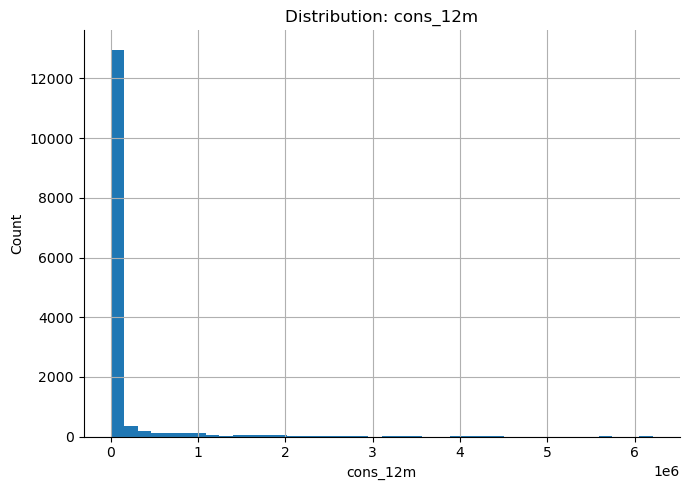

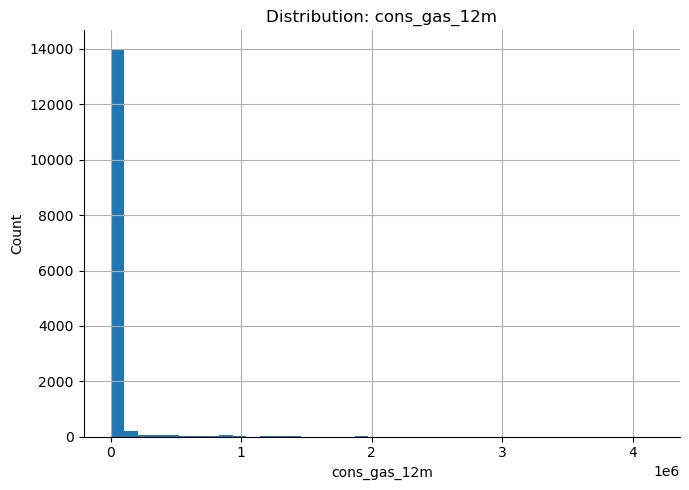

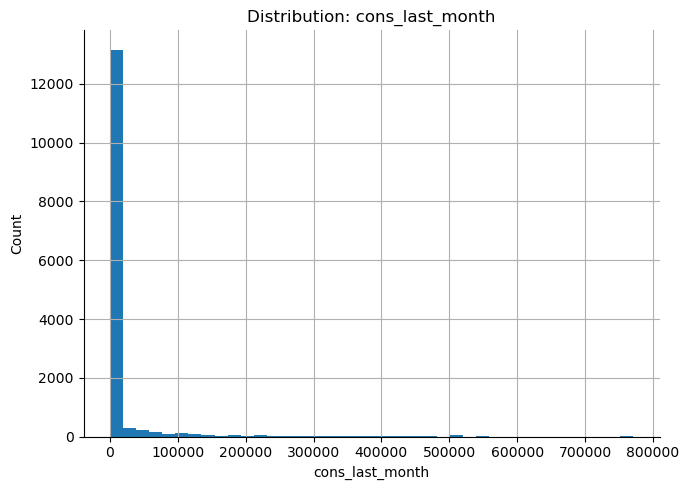

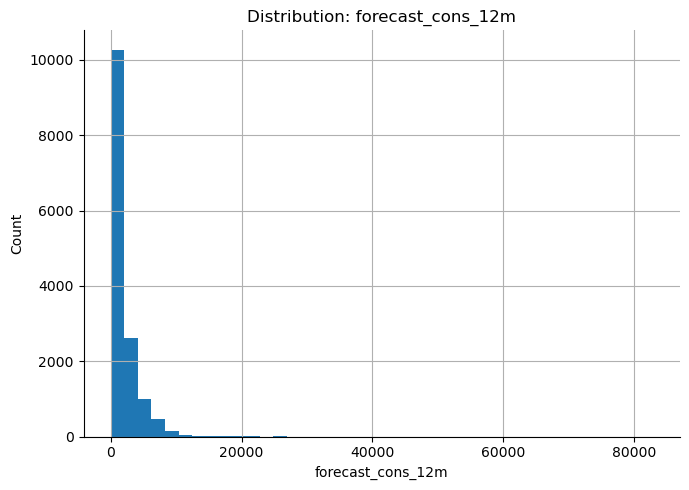

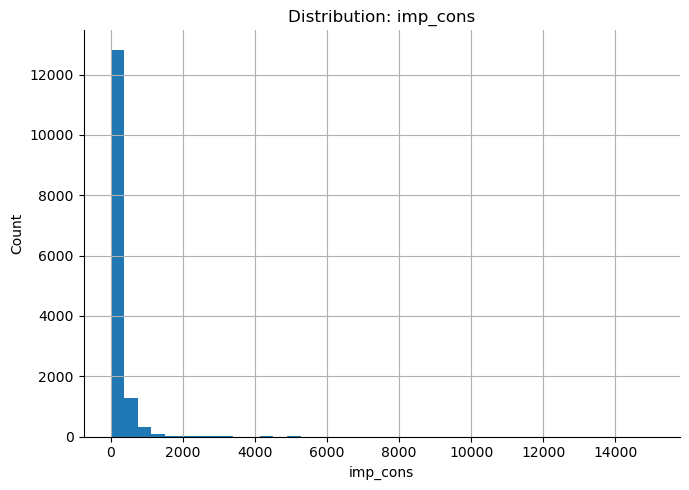

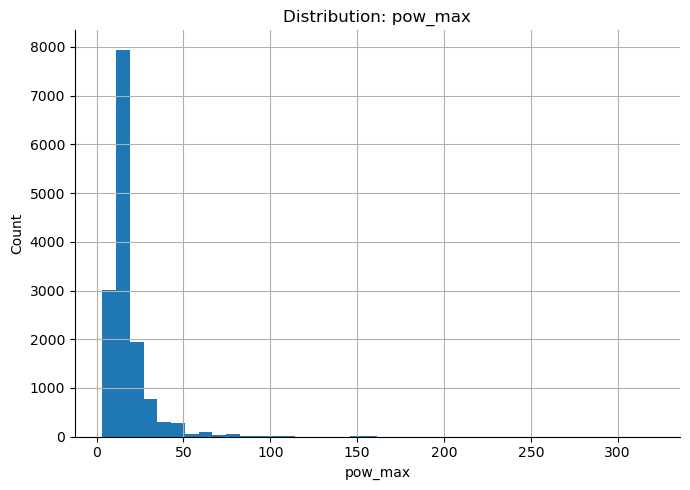

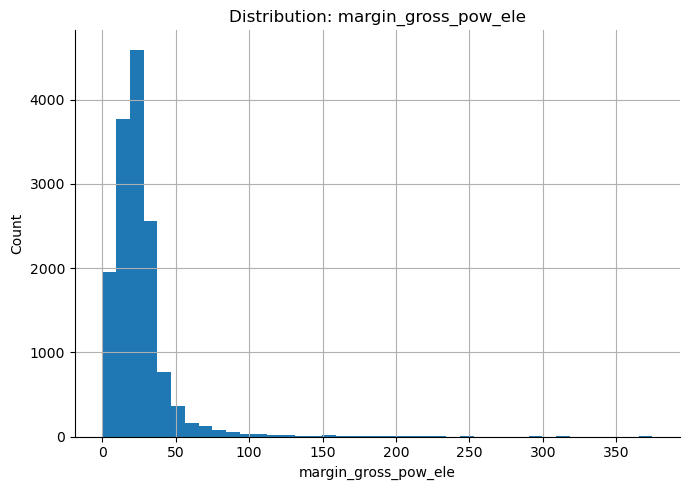

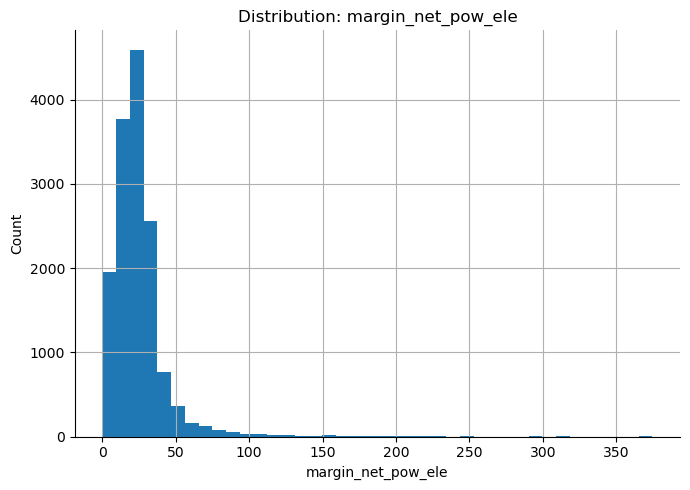

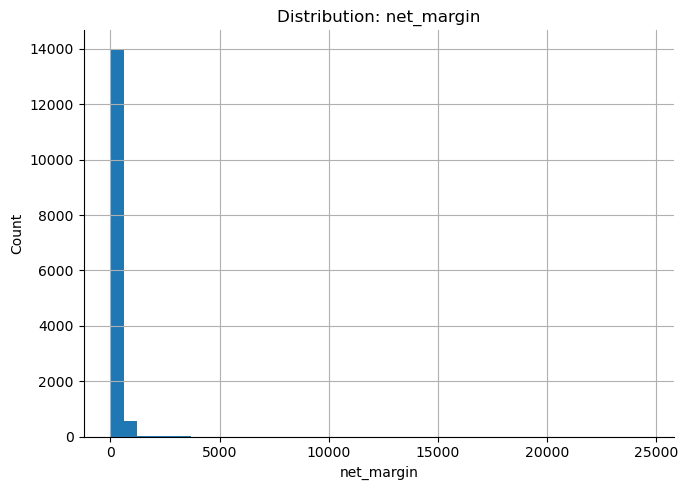

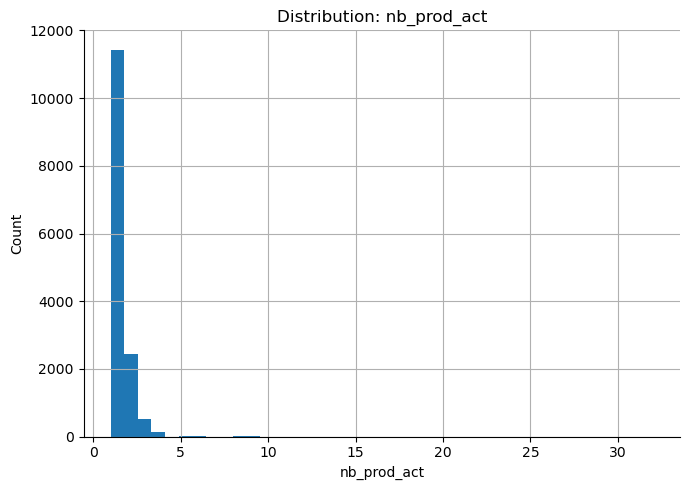

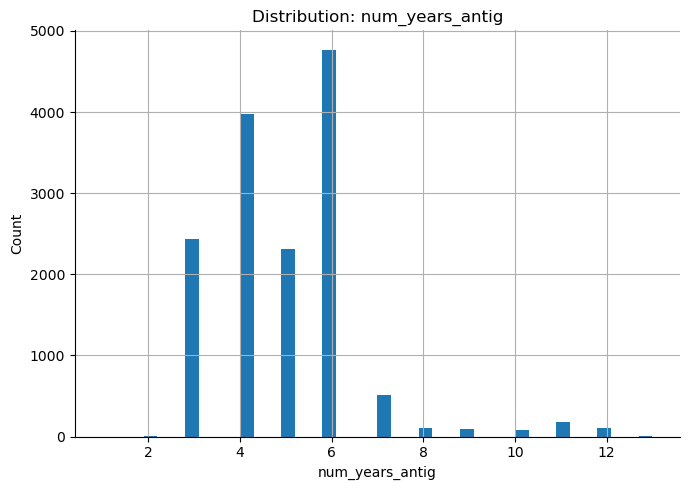

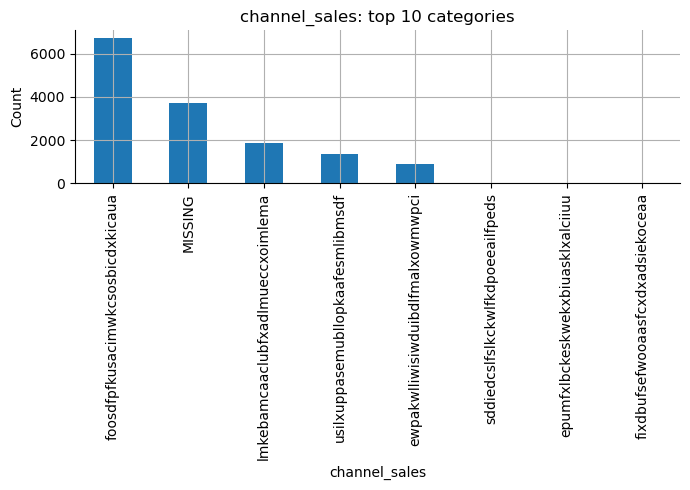

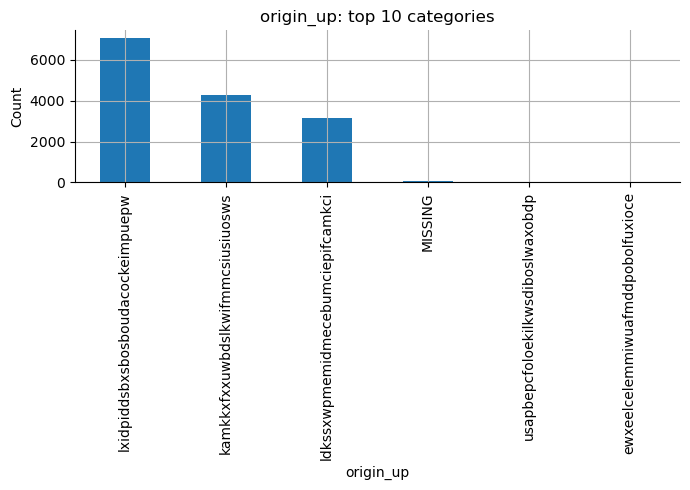

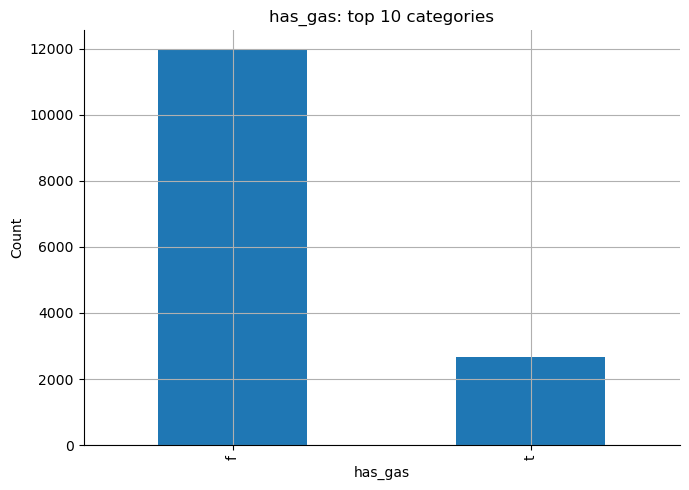

,mean,count
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,0.121410,6754
usilxuppasemubllopkaafesmlibmsdf,0.100364,1375
ewpakwlliwisiwduibdlfmalxowmwpci,0.083987,893
MISSING,0.075973,3725
lmkebamcaaclubfxadlmueccxoimlema,0.055887,1843


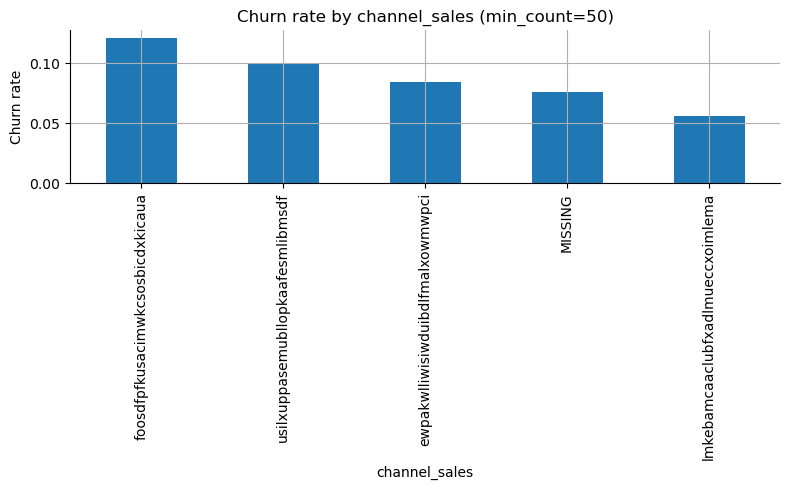

,mean,count
origin_up,,
lxidpiddsbxsbosboudacockeimpuepw,0.125828,7097
ldkssxwpmemidmecebumciepifcamkci,0.083863,3148
MISSING,0.062500,64
kamkkxfxxuwbdslkwifmmcsiusiuosws,0.060084,4294


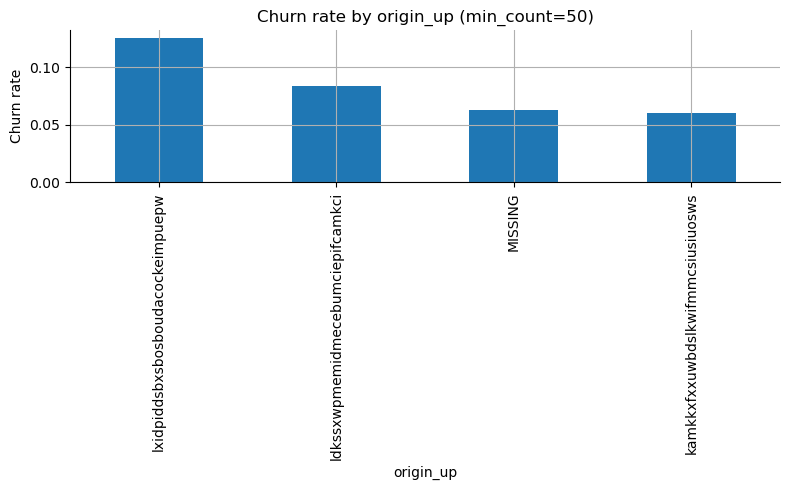

,mean,count
has_gas,,
f,0.100544,11955
t,0.081856,2651


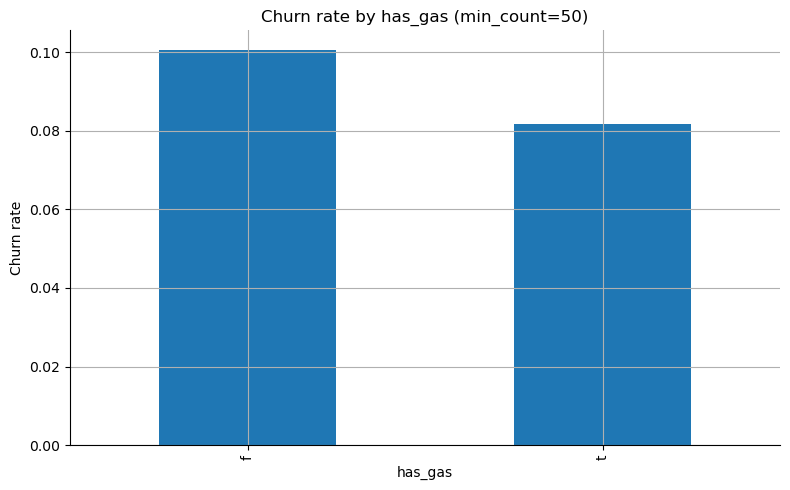

In [44]:
# =========================================================
# 6) Visualise key distributions (client)
#    - Distributions for numeric columns
#    - Top categories and churn by category for selected categoricals
# =========================================================

# Numeric distributions (choose a relevant subset)
cand_num = [
    "cons_12m", "cons_gas_12m", "cons_last_month",
    "forecast_cons_12m", "imp_cons", "pow_max",
    "margin_gross_pow_ele", "margin_net_pow_ele", "net_margin",
    "nb_prod_act", "num_years_antig"
]
plot_cols = [c for c in cand_num if c in client_df.columns]

for col in plot_cols:
    plt.figure()
    client_df[col].dropna().plot(kind="hist", bins=40)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"hist_{col}.png", dpi=180)
    plt.show()

# Helper: bar plot for top categories
def bar_top_categories(df: pd.DataFrame, col: str, top_k: int = 10):
    vc = df[col].value_counts(dropna=False).head(top_k)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"{col}: top {top_k} categories")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"bar_{col}_top{top_k}.png", dpi=180)
    plt.show()

for c in ["activity_new", "channel_sales", "origin_up", "has_gas"]:
    if c in client_df.columns:
        bar_top_categories(client_df, c, top_k=10)

# Churn rate by selected categoricals (min_count to avoid tiny groups)
def churn_rate_by_cat(df: pd.DataFrame, cat_col: str, min_count: int = 50):
    if {"churn", cat_col}.issubset(df.columns):
        grp = df.groupby(cat_col)["churn"].agg(["mean", "count"]).sort_values("mean", ascending=False)
        grp = grp[grp["count"] >= min_count]
        display(grp.head(10))
        plt.figure(figsize=(8,5))
        grp["mean"].head(15).plot(kind="bar")
        plt.title(f"Churn rate by {cat_col} (min_count={min_count})")
        plt.ylabel("Churn rate")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"churn_rate_by_{cat_col}.png", dpi=180)
        plt.show()

for c in ["activity_new", "channel_sales", "origin_up", "has_gas"]:
    if c in client_df.columns:
        churn_rate_by_cat(client_df, c)

### Additional step: Outlier detection through boxplots

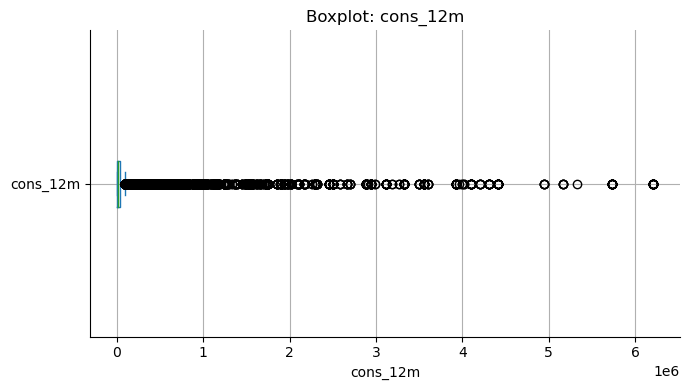

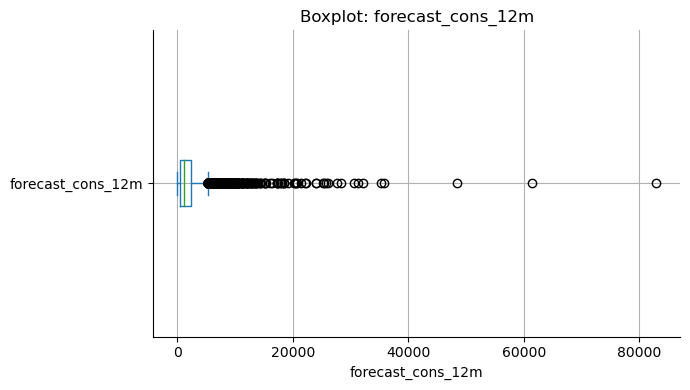

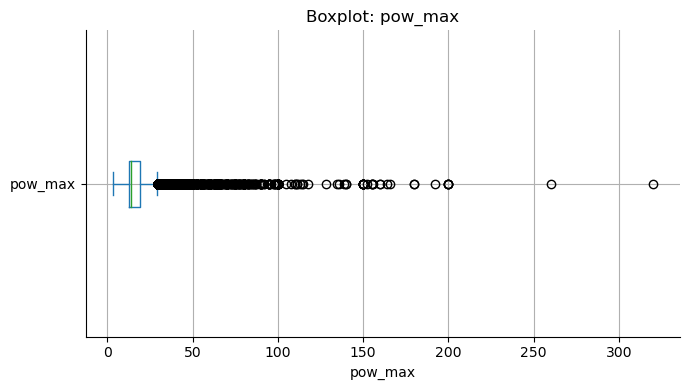

In [45]:
# =========================================================
# Additional step: Outlier detection through boxplots
#   - Highlight skewness and extreme values in key numeric columns
#   - Complements histograms by making tails and outliers more visible
# =========================================================

# Candidate numeric columns where skewness/outliers are expected
boxplot_cols = [
    "cons_12m",           # 12-month consumption
    "forecast_cons_12m",  # forecasted 12-month consumption
    "pow_max"             # subscribed maximum power
]

for col in boxplot_cols:
    if col in client_df.columns:
        plt.figure(figsize=(7, 4))
        client_df[col].dropna().plot(kind="box", vert=False)
        plt.title(f"Boxplot: {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"boxplot_{col}.png", dpi=180)
        plt.show()

### Build price features per customer (stable)

In [46]:
# =========================================================
# 7) Summarise prices to customer level (stable features)
#    - last, median, std, simple trend (slope) for var/fix levels
#    - defensible, explainable features for EDA
# =========================================================

def _row_avg_price(row: pd.Series, cols: list[str]) -> float:
    vals = [row[c] for c in cols if pd.notna(row[c])]
    return float(np.mean(vals)) if len(vals) else np.nan

if all_price_cols:
    price_df = price_df.copy()
    price_df["var_level"] = price_df.apply(lambda r: _row_avg_price(r, price_cols_var), axis=1) if price_cols_var else np.nan
    price_df["fix_level"] = price_df.apply(lambda r: _row_avg_price(r, price_cols_fix), axis=1) if price_cols_fix else np.nan

    # Keep only rows with valid date
    price_df = price_df[pd.notna(price_df["price_date"])]

    def _agg_per_id(g: pd.DataFrame) -> pd.Series:
        g = g.sort_values("price_date")

        # Last observed levels
        last_var = g["var_level"].dropna().iloc[-1] if g["var_level"].notna().any() else np.nan
        last_fix = g["fix_level"].dropna().iloc[-1] if g["fix_level"].notna().any() else np.nan

        # Median & volatility (std)
        med_var = g["var_level"].median()
        med_fix = g["fix_level"].median()
        std_var = g["var_level"].std()
        std_fix = g["fix_level"].std()

        # Simple trend slope using days since first observation (avoids dtype warnings)
        slope_var = np.nan
        slope_fix = np.nan
        if g["var_level"].notna().sum() >= 3:
            x = (g.loc[g["var_level"].notna(), "price_date"] - g["price_date"].min()).dt.days.to_numpy()
            y = g.loc[g["var_level"].notna(), "var_level"].to_numpy()
            slope_var = np.polyfit(x, y, 1)[0]
        if g["fix_level"].notna().sum() >= 3:
            x = (g.loc[g["fix_level"].notna(), "price_date"] - g["price_date"].min()).dt.days.to_numpy()
            y = g.loc[g["fix_level"].notna(), "fix_level"].to_numpy()
            slope_fix = np.polyfit(x, y, 1)[0]

        return pd.Series({
            "last_var_level": last_var,
            "last_fix_level": last_fix,
            "median_var_level": med_var,
            "median_fix_level": med_fix,
            "std_var_level": std_var,
            "std_fix_level": std_fix,
            "slope_var_level": slope_var,
            "slope_fix_level": slope_fix,
            "price_obs_count": len(g)
        })

    price_per_id = price_df.groupby("id", as_index=False).apply(_agg_per_id).reset_index(drop=True)
    print("\nPrice per id (head):")
    display(price_per_id.head(3))

    # Persist for audit / modelling handoff
    price_per_id.to_csv(OUT_DIR / "price_features_per_id.csv", index=False)


Price per id (head):


,id,last_var_level,last_fix_level,median_var_level,median_fix_level,std_var_level,std_fix_level,slope_var_level,slope_fix_level,price_obs_count
0,0002203ffbb812588b632b9e628cc38d,0.098433,27.152590,0.100102,27.152590,0.001974,0.042277,-0.000011,0.000248,12.0
1,0004351ebdd665e6ee664792efc4fd13,0.047981,14.814903,0.049349,14.814903,0.000732,0.029177,-0.000006,0.000218,12.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.067093,15.314903,0.067093,15.314903,0.008669,0.257464,0.000066,0.002012,12.0


### Merge client data + price features

In [47]:
# =========================================================
# 8) Merge client data + price features
# =========================================================
if "id" in client_df.columns and all_price_cols:
    merged = client_df.merge(price_per_id, on="id", how="left")
else:
    merged = client_df.copy()

print("\nMerged shape:", merged.shape)
display(merged.head(3))
merged.to_csv(OUT_DIR / "merged_client_price_sample.csv", index=False)


Merged shape: (14606, 35)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,last_var_level,last_fix_level,median_var_level,median_fix_level,std_var_level,std_fix_level,slope_var_level,slope_fix_level,price_obs_count
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.077172,14.755643,0.100302,27.043980,0.006567,3.561999,-0.000038,-0.015242,12.0
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.049200,14.814903,0.050456,14.755644,0.007876,0.026801,0.000011,0.000184,12.0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.085402,14.814903,0.086783,14.814903,0.000818,0.029177,-0.000006,0.000218,12.0


### Initial hypothesis tests: price ↔ churn


Point-biserial correlation with churn (continuous price features):


,feature,pointbiserial_r,p_value,n
0,median_fix_level,0.053346,1.109936e-10,14606
1,last_fix_level,0.051618,4.323254e-10,14606
2,median_var_level,0.041494,5.262294e-07,14606
3,last_var_level,0.039911,1.400563e-06,14606
4,std_var_level,0.033791,4.414113e-05,14606
5,std_fix_level,0.019031,2.145053e-02,14606
6,slope_fix_level,-0.004281,6.048788e-01,14606
7,slope_var_level,-0.009889,2.320843e-01,14606


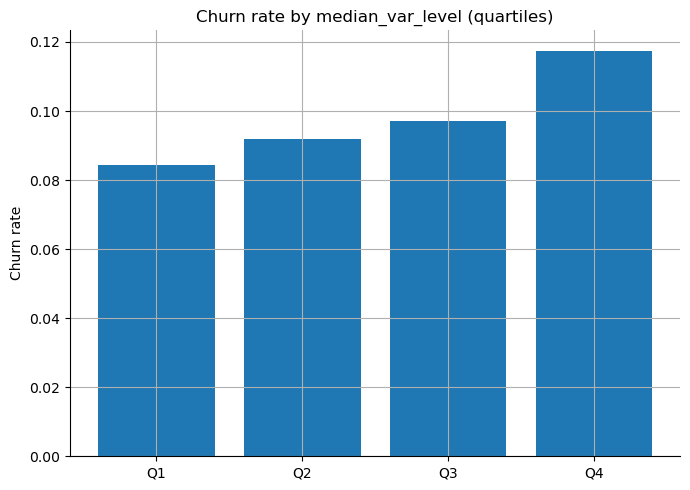

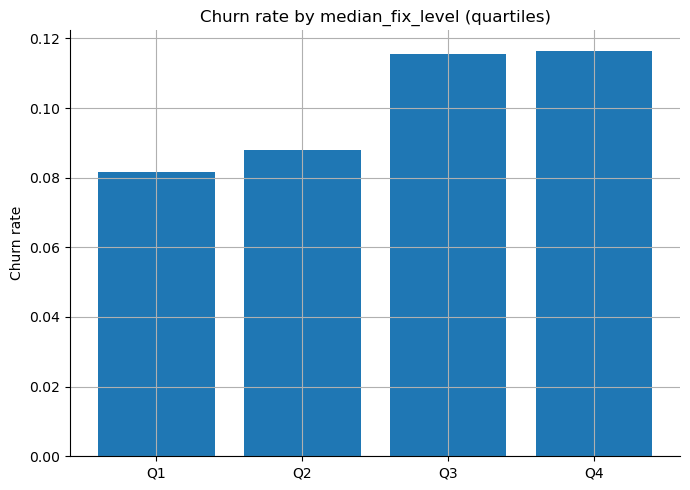

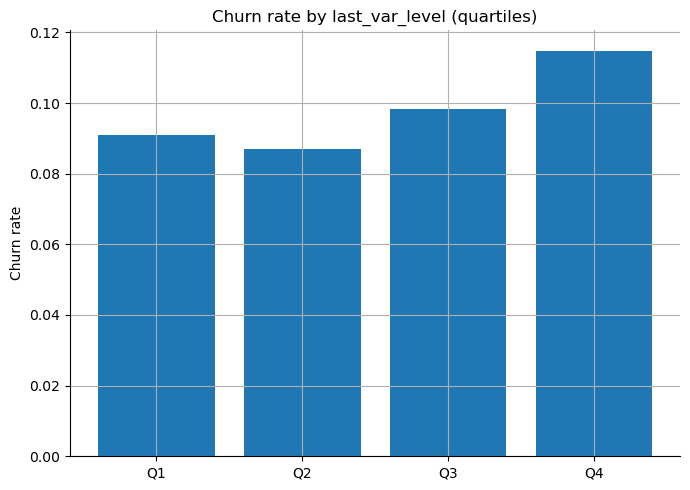

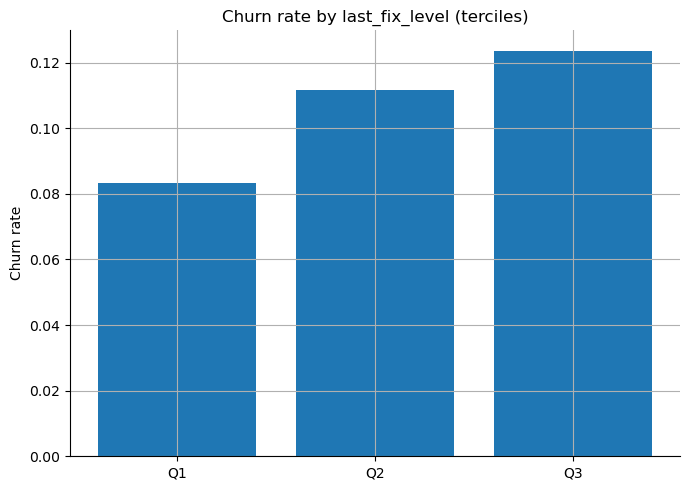

In [48]:
# =========================================================
# 9) Initial hypothesis tests: price ↔ churn
#    - Correlate continuous price features with churn (point-biserial)
#    - Segment price levels into quantiles (e.g., quartiles) and compare churn rates
#    - Persist tabular outputs and save simple, explainable charts
# =========================================================

if "churn" in merged.columns:

    # ---------------------------------------------------------------------
    # 9a) Point-biserial correlation (continuous price feature ↔ binary target)
    # ---------------------------------------------------------------------
    # Candidate features engineered from price history (per-customer level)
    corr_candidates = [
        "last_var_level", "last_fix_level",
        "median_var_level", "median_fix_level",
        "std_var_level", "std_fix_level",
        "slope_var_level", "slope_fix_level",
    ]
    corr_candidates = [c for c in corr_candidates if c in merged.columns]

    corr_rows = []
    for col in corr_candidates:
        # Use only rows where both the feature and target are available
        s = merged[col]
        mask = s.notna() & merged["churn"].notna()

        # Guardrail against unstable statistics on tiny samples
        if mask.sum() > 20:
            r, p = pointbiserialr(merged.loc[mask, "churn"], s[mask])
            corr_rows.append({
                "feature": col,
                "pointbiserial_r": float(r),
                "p_value": float(p),
                "n": int(mask.sum()),
            })

    corr_tbl = (
        pd.DataFrame(corr_rows)
          .sort_values("pointbiserial_r", ascending=False)
          .reset_index(drop=True)
    )

    print("\nPoint-biserial correlation with churn (continuous price features):")
    display(corr_tbl)
    corr_tbl.to_csv(OUT_DIR / "price_churn_pointbiserial.csv", index=False)

    # ---------------------------------------------------------------------
    # 9b) Churn by price quantile — business-friendly segmentation
    #     (handles tied cut-points by reducing the number of bins)
    # ---------------------------------------------------------------------
    def churn_by_quantile(df: pd.DataFrame, feat: str) -> pd.DataFrame | None:
        """
        Segment a continuous price feature into quantile-based bins (target=4),
        then compute churn rates per segment.

        - Drops duplicate cut points gracefully (e.g., if many identical values).
        - Returns a tidy DataFrame: [feature, bin_label, churn_rate, count].
        """
        s = df[feat]
        mask = s.notna() & df["churn"].notna()

        # Skip if sample size is too small for a stable slice
        if mask.sum() < 50:
            return None

        # First pass: request 4-quantiles (quartiles) and retrieve the actual bin edges.
        # If there are tied quantiles, pandas will drop duplicate edges.
        _, bins = pd.qcut(
            s[mask],
            q=4,
            retbins=True,
            duplicates="drop"  # ensures unique edges if ties occur
        )

        # Build labels to match the actual number of bins
        n_bins = len(bins) - 1
        if n_bins < 2:
            return None  # not enough variation to segment meaningfully

        labels = [f"Q{i+1}" for i in range(n_bins)]

        # Second pass: cut using the resolved number of bins & labels
        q = pd.qcut(s[mask], q=n_bins, labels=labels)

        # Compute churn rate and count per segment
        tmp = df.loc[mask].assign(bin_label=q)
        out = (
            tmp.groupby("bin_label", observed=True)["churn"]
               .agg(churn_rate="mean", count="size")
               .reset_index()
        )
        out["feature"] = feat
        return out

    # Features to segment for an explainable price–churn view
    quantile_features = [
        "median_var_level", "median_fix_level",
        "last_var_level", "last_fix_level",
    ]
    quantile_features = [f for f in quantile_features if f in merged.columns]

    quantile_results = []
    for feat in quantile_features:
        res = churn_by_quantile(merged, feat)
        if res is not None:
            quantile_results.append(res)

    if quantile_results:
        qb = pd.concat(quantile_results, ignore_index=True)

        # Persist tabular output (keep column name 'bin_label' consistent)
        qb.to_csv(OUT_DIR / "churn_by_price_quantile.csv", index=False)

        # Helper to name the segmentation based on number of bins (for chart titles)
        def _segmentation_name(n_bins: int) -> str:
            return {
                2: "halves",
                3: "terciles",
                4: "quartiles",
                5: "quintiles",
            }.get(n_bins, f"{n_bins}-quantiles")

        # Plot a simple bar chart per feature
        for feat in qb["feature"].unique():
            sub = qb[qb["feature"] == feat].copy()

            # Number of bins present for this feature
            n_bins = sub.shape[0]
            seg_name = _segmentation_name(n_bins)

            # Ensure bins display in natural order: Q1, Q2, ...
            # If labels are categorical, preserve order; otherwise sort by label string.
            if pd.api.types.is_categorical_dtype(sub["bin_label"]):
                sub["bin_label"] = sub["bin_label"].cat.as_ordered()
                sub = sub.sort_values("bin_label")
            else:
                sub = sub.sort_values("bin_label")

            plt.figure(figsize=(7, 5))
            plt.bar(sub["bin_label"].astype(str), sub["churn_rate"])
            plt.ylabel("Churn rate")
            plt.title(f"Churn rate by {feat} ({seg_name})")
            plt.tight_layout()
            plt.savefig(FIG_DIR / f"churn_by_{feat}_{seg_name}.png", dpi=180, bbox_inches="tight")
            plt.show()

### Optional leakage screen (fast)

In [49]:
# =========================================================
# 10) Optional: simple target leakage checks
#    - flag potentially future-looking or post-treatment fields
# =========================================================
suspects = [c for c in client_df.columns if "forecast" in c or "margin" in c]
if "churn" in client_df.columns and suspects:
    print("\nQuick leakage screen (corr with churn):")
    rows = []
    for col in suspects:
        if pd.api.types.is_numeric_dtype(client_df[col]):
            s = client_df[col]
            mask = s.notna()
            if mask.sum() > 20:
                r, p = pointbiserialr(client_df.loc[mask, "churn"], s[mask])
                rows.append({"feature": col, "pointbiserial_r": r, "p_value": p, "n": int(mask.sum())})
    if rows:
        leak_tbl = pd.DataFrame(rows).sort_values("pointbiserial_r", ascending=False)
        display(leak_tbl)
        leak_tbl.to_csv(OUT_DIR / "leakage_screen.csv", index=False)


Quick leakage screen (corr with churn):


,feature,pointbiserial_r,p_value,n
8,margin_net_pow_ele,0.095772,4.111908e-31,14606
7,margin_gross_pow_ele,0.095725,4.392533e-31,14606
3,forecast_meter_rent_12m,0.044245,8.825525e-08,14606
9,net_margin,0.041135,6.591893e-07,14606
5,forecast_price_energy_peak,0.029315,3.950817e-04,14606
2,forecast_discount_energy,0.017026,3.962342e-02,14606
6,forecast_price_pow_off_peak,0.014778,7.410850e-02,14606
0,forecast_cons_12m,0.012949,1.176025e-01,14606
1,forecast_cons_year,-0.002558,7.572685e-01,14606
4,forecast_price_energy_off_peak,-0.010837,1.903135e-01,14606


### Executive EDA snapshot (print-out)

In [50]:
# =========================================================
# 11) Executive EDA snapshot (concise)
# =========================================================
print("\n================ EXECUTIVE EDA SNAPSHOT ================")
if "churn" in client_df.columns:
    print(f"Churn base rate: {client_df['churn'].mean():.3f}")
print(f"Clients: {client_df.shape[0]:,} | Price rows: {price_df.shape[0]:,}")

if all_price_cols and 'merged' in globals():
    cov = merged[["last_var_level","median_var_level","last_fix_level","median_fix_level"]].notna().mean().round(3)
    print("\nPrice feature coverage (% non-null):")
    print(cov.to_string())

if 'corr_tbl' in globals() and not corr_tbl.empty:
    head_corr = corr_tbl.head(5).copy()
    head_corr["pointbiserial_r"] = head_corr["pointbiserial_r"].round(3)
    head_corr["p_value"] = head_corr["p_value"].apply(lambda x: f"{x:.2e}")
    print("\nTop price ↔ churn correlations (point-biserial):")
    print(head_corr.to_string(index=False))

print("\nKey figures saved to   :", FIG_DIR.resolve())
print("Tabular artifacts saved:", OUT_DIR.resolve())
print("========================================================")


================ EXECUTIVE EDA SNAPSHOT ================
Churn base rate: 0.097
Clients: 14,606 | Price rows: 193,002

Price feature coverage (% non-null):
last_var_level      1.0
median_var_level    1.0
last_fix_level      1.0
median_fix_level    1.0

Top price ↔ churn correlations (point-biserial):
         feature  pointbiserial_r  p_value     n
median_fix_level            0.053 1.11e-10 14606
  last_fix_level            0.052 4.32e-10 14606
median_var_level            0.041 5.26e-07 14606
  last_var_level            0.040 1.40e-06 14606
   std_var_level            0.034 4.41e-05 14606

Key figures saved to   : C:\Users\richa\figures_bcgx
Tabular artifacts saved: C:\Users\richa\outputs
